In [1]:
import requests
from datetime import  datetime, timedelta, timezone, date
from glob import glob
JST = timezone(timedelta(hours=+9))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fastprogress import progress_bar as pb
sns.set()

In [3]:
csv_files = glob('data/**/*.csv', recursive=True)

In [5]:
df_files = pd.DataFrame({
    'file': csv_files,
    'date': [date(int(file.split('/')[-1].strip('.csv')[:4]), int(file.split('/')[-1].strip('.csv')[4:6]), int(file.split('/')[-1].strip('.csv')[6:])) for file in csv_files]
})

In [6]:
df_files.sort_values(by='date', inplace=True)

In [7]:
df_files.reset_index(inplace=True, drop=True)

In [9]:
df = pd.concat([pd.read_csv(f) for f in pb(df_files.file)])

In [10]:
df['datetime_jst'] = pd.to_datetime(df['datetime'].map(lambda x: x.replace('+09:00', '')))

In [11]:
df

,blockchain,symbol,id,transaction_type,hash,timestamp,amount,amount_usd,transaction_count,datetime,from_address,from_owner,from_owner_type,to_address,to_owner,to_owner_type,datetime_jst
0,tron,usdt,1504028260,transfer,07e45965d8108b1409baf30e191b0c7a61fc2299bc9450...,1617940023,999999.00,1001447.06,1,2021-04-09 12:47:03+09:00,TNaRAoLUyYEV2uF7GUrzSjRQTU8v5ZJ5VR,huobi,exchange,TQK1h5T7Y31r1LcDsYMRTporf4nYkRVVnT,NaN,unknown,2021-04-09 12:47:03
1,ethereum,usdt,1504028885,transfer,87116c44808dc5a8a4f22001074277eb2d06f03a1a97ea...,1617940042,3000000.00,3008048.80,1,2021-04-09 12:47:22+09:00,985cb8d1db2db971071aacf6222df421538332d7,NaN,unknown,0582f66446a2d67012ebc5baef4389604cfd91a9,binance,exchange,2021-04-09 12:47:22
2,ethereum,usdt,1504029026,transfer,7345896d35f21f09a23b187859779995c67fcea71e9a5b...,1617940052,757140.25,759171.56,1,2021-04-09 12:47:32+09:00,008cf75d1eeaf94420eec9f5edb89a6a8abd10a9,NaN,unknown,051acf8d69a18d6a6e4dd063b39501e69704ac50,NaN,unknown,2021-04-09 12:47:32
3,ethereum,bnt,1504039397,transfer,d31d69c6d4f18cdd6ccbe3dfdefe4ed75a99617dafa55d...,1617940102,71192.79,528297.75,1,2021-04-09 12:48:22+09:00,6af4a7b0cd9ff7ec82d15d4d662be5a874fa7a48,NaN,unknown,fb86c5e06f6c273401666e451d17d18b2b143b89,binance,exchange,2021-04-09 12:48:22
4,ethereum,eth,1504040624,transfer,4e3d357146fb88677c53cc9041009f6b8d71bc8dcb1c32...,1617940177,1000.00,2067181.90,1,2021-04-09 12:49:37+09:00,d897fe50cc3f57ddea02c8c21d5ff3eb03387310,NaN,unknown,e5782724e87bcd5a1f48737ff6cfeaf875ab5873,binance,exchange,2021-04-09 12:49:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,ripple,xrp,1759654237,transfer,BB7D35CF3BCAB6852D77E6CF6AAA7034E195F6B0825E31...,1639062191,4200000.00,3736305.20,1,2021-12-10 00:03:11+09:00,rHBXf41ccuT38r54gMUwtmqm9EtsJ5aLm1,bitso,exchange,rLSn6Z3T8uCxbcd1oxwfGQN1Fdn5CyGujK,bitso,exchange,2021-12-10 00:03:11
99,tron,usdt,1759654252,transfer,2645fad1e26af919e422e6d2c94c12e918ed856b54ffce...,1639062210,1200000.00,1200000.00,1,2021-12-10 00:03:30+09:00,TCLnmKSJGgnagcxtq3nMu1SVSnnQ3WoUiF,NaN,unknown,TJzEAaxmKwpb7TrokTo7wzj3U3ZBGMMXKh,NaN,unknown,2021-12-10 00:03:30
100,ripple,xrp,1759654314,transfer,6B254DFD47A6659F808088FDC991BD0AE5F4D92E984479...,1639062220,1000000.00,889596.50,1,2021-12-10 00:03:40+09:00,rLSn6Z3T8uCxbcd1oxwfGQN1Fdn5CyGujK,bitso,exchange,rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv,bitstamp,exchange,2021-12-10 00:03:40
101,ethereum,usdt,1759654357,transfer,131891889c9cae3069011e7356941c902f8560ba852809...,1639062200,2502509.50,2502509.50,1,2021-12-10 00:03:20+09:00,56178a0d5f301baf6cf3e1cd53d9863437345bf9,NaN,unknown,1149e9143c407f3be1df24c463e48963c6de1715,huobi,exchange,2021-12-10 00:03:20


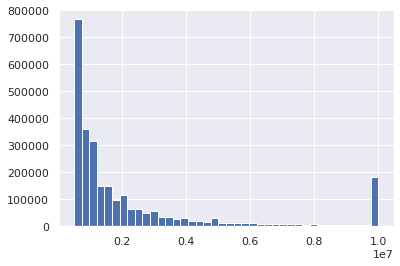

In [12]:
df['amount_usd'].clip(0, 10000000).hist(bins=40)

<BarContainer object of 5000 artists>

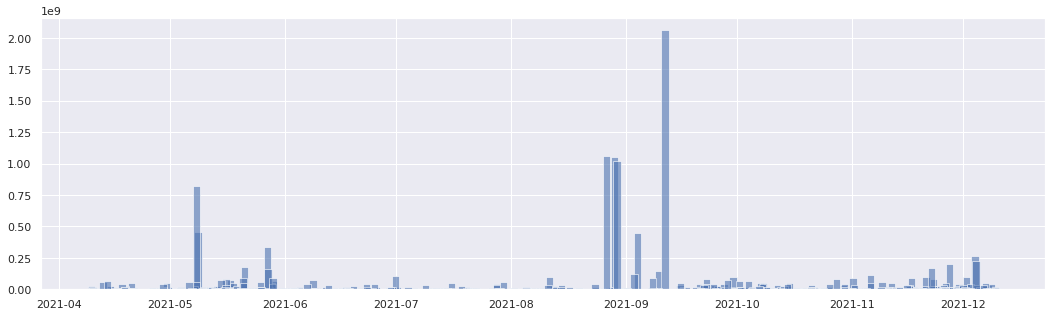

In [18]:
df_sample = df.sample(5000)
plt.figure(figsize=(18, 5))
plt.bar(df_sample['datetime_jst'], df_sample['amount_usd'], width=2.0, alpha=0.6)

In [87]:
df_btc_return = pd.read_csv('/content/drive/MyDrive/data/crypto/historical/gmo/return_btc_5min.csv')
df_btc_return['timestamp'] = pd.to_datetime(df_btc_return['timestamp'])
df_btc_return.set_index('timestamp', inplace=True)

In [88]:
df_whale_5min = df.set_index('datetime_jst').resample('5T').sum()
# df_whale_5min = df.set_index('datetime_jst').resample('5T').mean()

In [89]:
df_whale_5min

,id,timestamp,amount,amount_usd,transaction_count
datetime_jst,,,,,
2021-04-09 12:45:00,9024206214,9707640593,5.506024e+06,8.039870e+06,6
2021-04-09 12:50:00,10528308044,11325582400,7.174712e+06,1.070766e+07,7
2021-04-09 12:55:00,10528341532,11325584065,5.890509e+06,9.996840e+06,7
2021-04-09 13:00:00,12032453110,12943528360,8.650461e+06,5.287419e+06,8
2021-04-09 13:05:00,121829139001,131053239225,7.631978e+07,3.145005e+08,81
...,...,...,...,...,...
2021-12-09 23:40:00,204118007399,190131068321,2.166942e+07,7.680315e+08,4735
2021-12-09 23:45:00,270984883482,252415423304,2.922162e+07,1.502103e+09,4178
2021-12-09 23:50:00,124934872887,116373366289,3.129331e+07,2.366216e+08,3724


In [90]:
df_whale_5min = df_whale_5min.dropna()

In [91]:
df_whale_5min

,id,timestamp,amount,amount_usd,transaction_count
datetime_jst,,,,,
2021-04-09 12:45:00,9024206214,9707640593,5.506024e+06,8.039870e+06,6
2021-04-09 12:50:00,10528308044,11325582400,7.174712e+06,1.070766e+07,7
2021-04-09 12:55:00,10528341532,11325584065,5.890509e+06,9.996840e+06,7
2021-04-09 13:00:00,12032453110,12943528360,8.650461e+06,5.287419e+06,8
2021-04-09 13:05:00,121829139001,131053239225,7.631978e+07,3.145005e+08,81
...,...,...,...,...,...
2021-12-09 23:40:00,204118007399,190131068321,2.166942e+07,7.680315e+08,4735
2021-12-09 23:45:00,270984883482,252415423304,2.922162e+07,1.502103e+09,4178
2021-12-09 23:50:00,124934872887,116373366289,3.129331e+07,2.366216e+08,3724


In [92]:
df_btc_return_whale = pd.merge(
    df_whale_5min, df_btc_return,
    how='inner',
    left_index=True, right_index=True,
)

In [93]:
df_btc_return_whale

,id,timestamp,amount,amount_usd,transaction_count,size_buy,price_buy,size_sell,price_sell,return_1h,return_3h,return_6h,return_12h,return_18h,return_24h,return_48h,return_72h,return_120h,return_168h,return_720h,return_1440h,return_2160h
2021-04-09 12:45:00,9024206214,9707640593,5.506024e+06,8.039870e+06,6,0.007323,6.432878e+06,0.011267,6.430974e+06,1.000505,0.993151,0.995066,0.989918,1.032497,1.025330,1.016957,1.028135,1.088193,1.035221,0.964438,0.559065,0.559231
2021-04-09 12:50:00,10528308044,11325582400,7.174712e+06,1.070766e+07,7,0.005535,6.432466e+06,0.049533,6.431765e+06,0.998705,0.993710,0.994953,0.990743,1.033052,1.023478,1.016980,1.027238,1.084315,1.036139,0.963961,0.559548,0.557234
2021-04-09 12:55:00,10528341532,11325584065,5.890509e+06,9.996840e+06,7,0.014723,6.437456e+06,0.027020,6.433812e+06,0.999461,0.992189,0.994176,0.989964,1.031817,1.021262,1.015901,1.026516,1.083318,1.034418,0.957101,0.559117,0.555864
2021-04-09 13:00:00,12032453110,12943528360,8.650461e+06,5.287419e+06,8,0.007400,6.437391e+06,0.031400,6.437713e+06,0.997370,0.992157,0.994999,0.991155,1.029452,1.022899,1.016186,1.026277,1.085602,1.031999,0.957027,0.559796,0.555155
2021-04-09 13:05:00,121829139001,131053239225,7.631978e+07,3.145005e+08,81,0.004335,6.440697e+06,0.048441,6.438695e+06,0.998135,0.990853,0.995302,0.990655,1.029730,1.021243,1.014597,1.025853,1.088450,1.030460,0.958948,0.557767,0.554763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 23:40:00,204118007399,190131068321,2.166942e+07,7.680315e+08,4735,0.023228,5.447621e+06,0.045943,5.449022e+06,1.005023,1.013851,1.004278,1.014515,0.986787,0.989541,1.026001,1.043952,1.006271,0.993344,NaN,NaN,NaN
2021-12-09 23:45:00,270984883482,252415423304,2.922162e+07,1.502103e+09,4178,0.020311,5.442565e+06,0.001550,5.441442e+06,1.005374,1.014257,1.005258,1.016595,0.990195,0.990357,1.025994,1.043602,1.007357,0.995220,NaN,NaN,NaN
2021-12-09 23:50:00,124934872887,116373366289,3.129331e+07,2.366216e+08,3724,0.015300,5.436934e+06,0.007600,5.435631e+06,1.005395,1.014645,1.006870,1.019319,0.992740,0.985031,1.027520,1.045016,1.012053,0.997235,NaN,NaN,NaN
2021-12-09 23:55:00,65107051968,60645289006,7.278325e+07,8.317259e+07,37,0.008600,5.413695e+06,0.011711,5.415209e+06,1.007521,1.018147,1.011728,1.022585,0.997941,0.987546,1.033119,1.050901,1.016592,0.999317,NaN,NaN,NaN


In [94]:
RETURN_COLS = [col for col in df_btc_return.columns if 'return' in col]

In [95]:
df_btc_return_whale[['amount_usd']+RETURN_COLS].corr()[['amount_usd']]

,amount_usd
amount_usd,1.000000
return_1h,-0.001563
return_3h,-0.002978
return_6h,-0.003297
return_12h,-0.003280
return_18h,-0.001996
return_24h,-0.002671
return_48h,-0.007981
return_72h,-0.005017
return_120h,0.000556


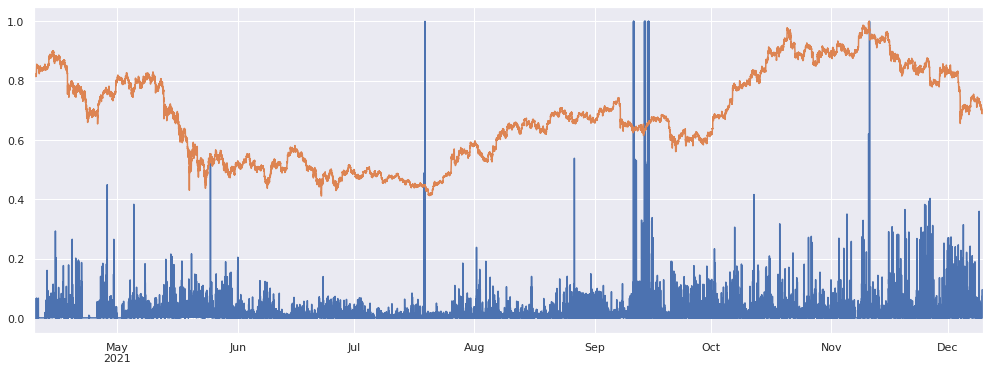

In [83]:
plt.figure(figsize=(17, 6))
(df_btc_return_whale['amount_usd'].clip(0, 20000000000)/20000000000).plot()
# df_btc_return_whale['return_1440h'].plot()
df_btc_return_whale['price_sell'].div(df_btc_return_whale['price_sell'].max()).plot()

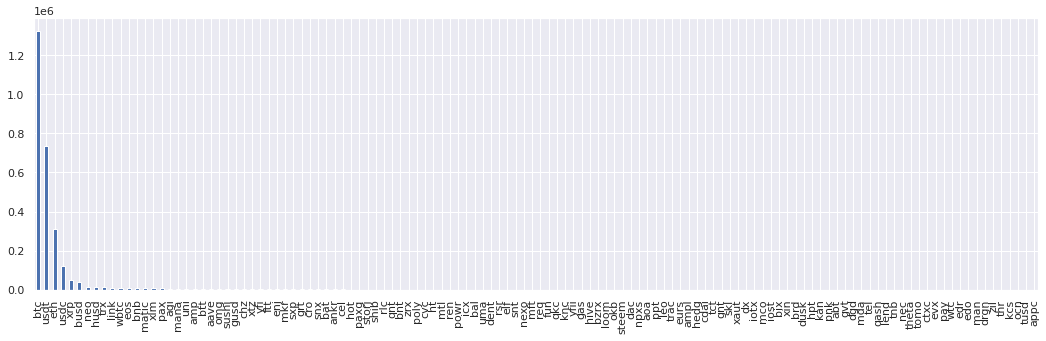

In [84]:
plt.figure(figsize=(18, 5))
df['symbol'].value_counts().sort_values(ascending=False).plot.bar()

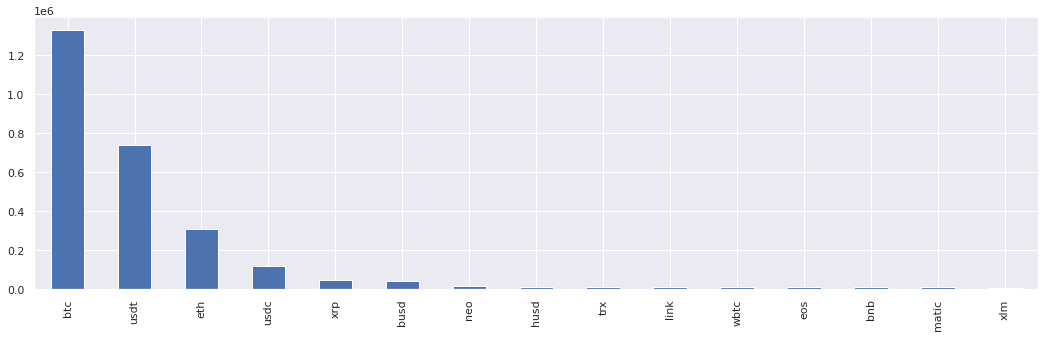

In [85]:
plt.figure(figsize=(18, 5))
df['symbol'].value_counts().sort_values(ascending=False)[:15].plot.bar()

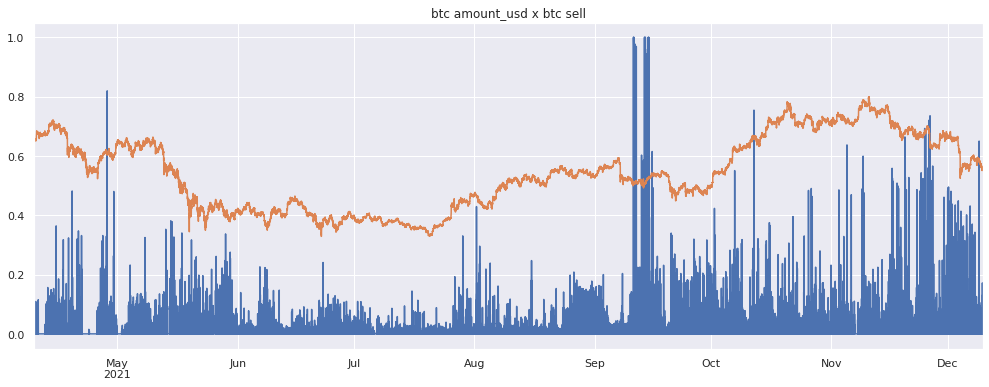

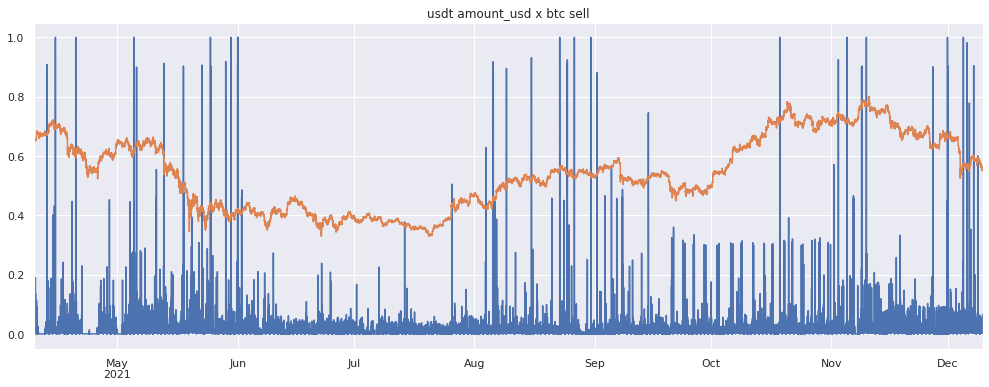

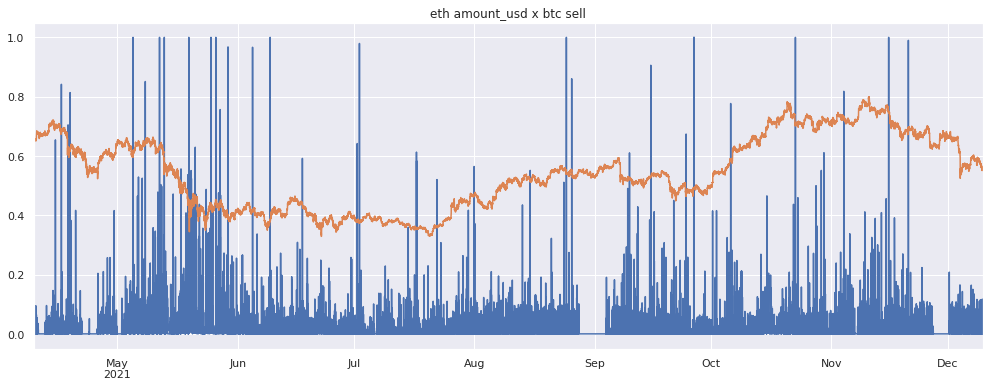

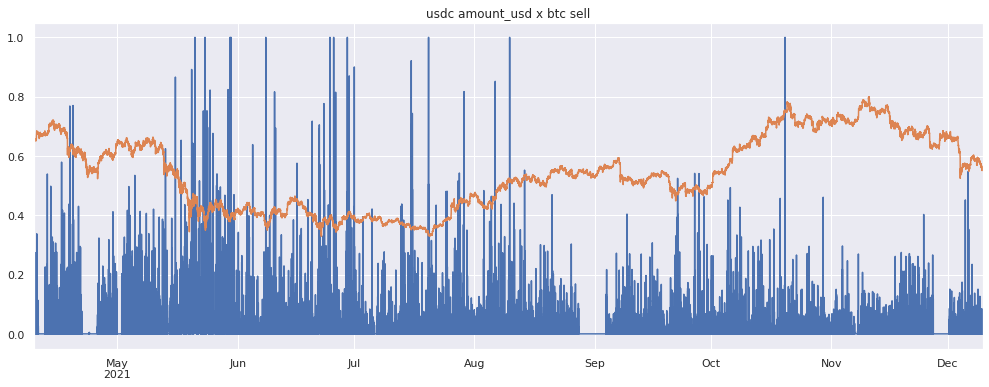

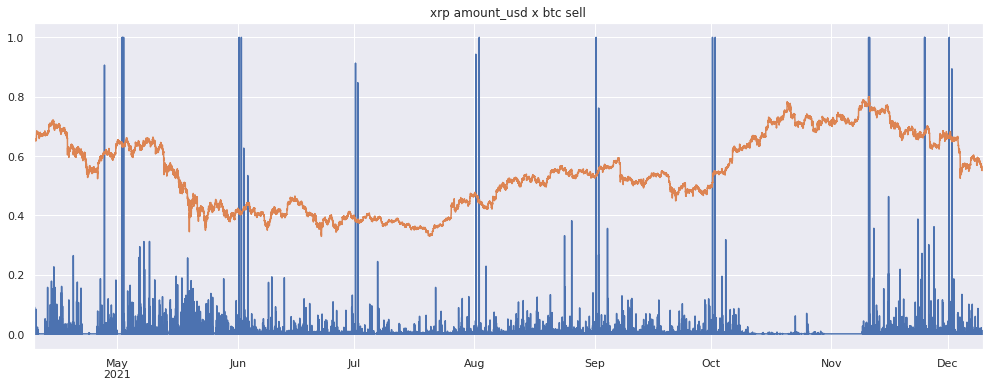

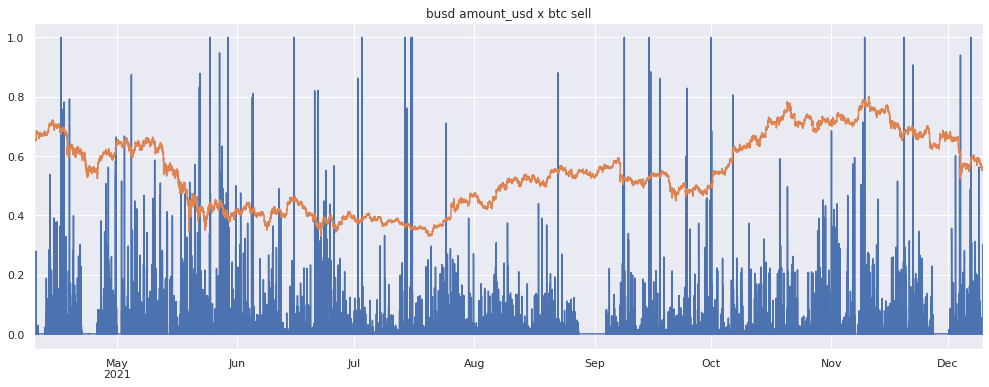

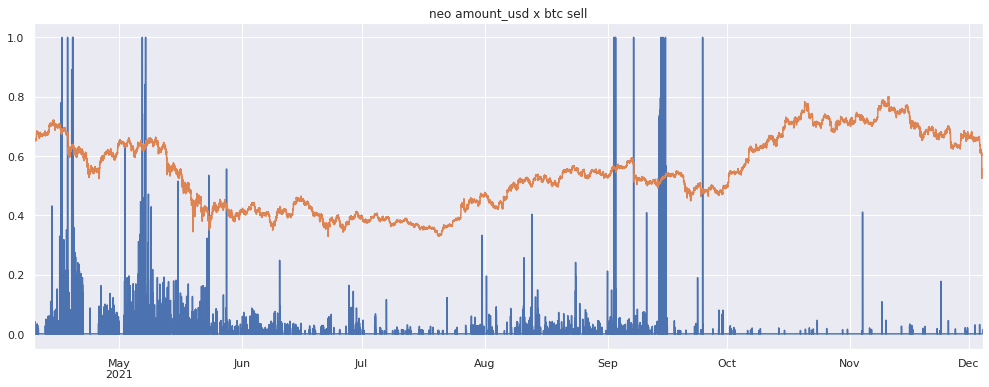

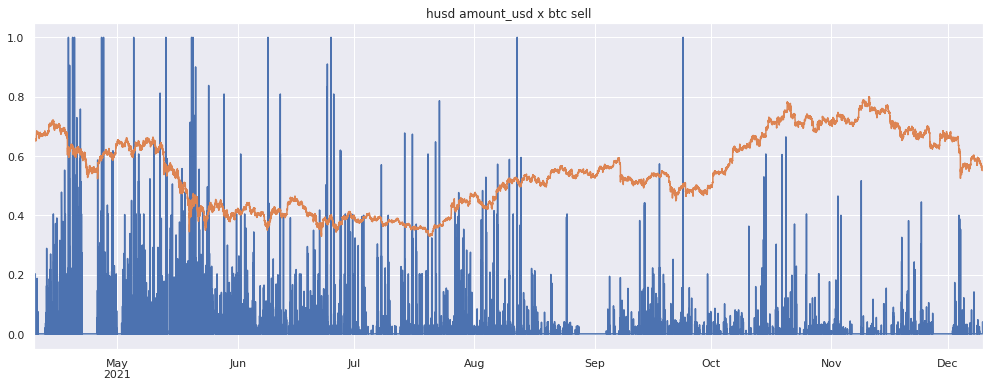

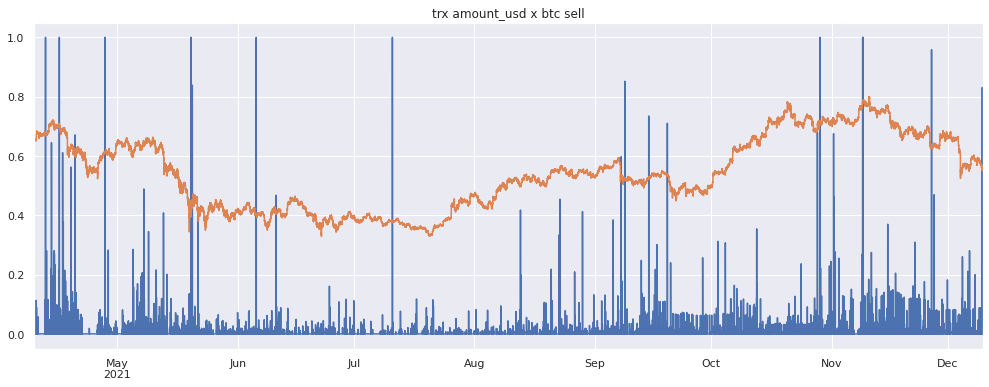

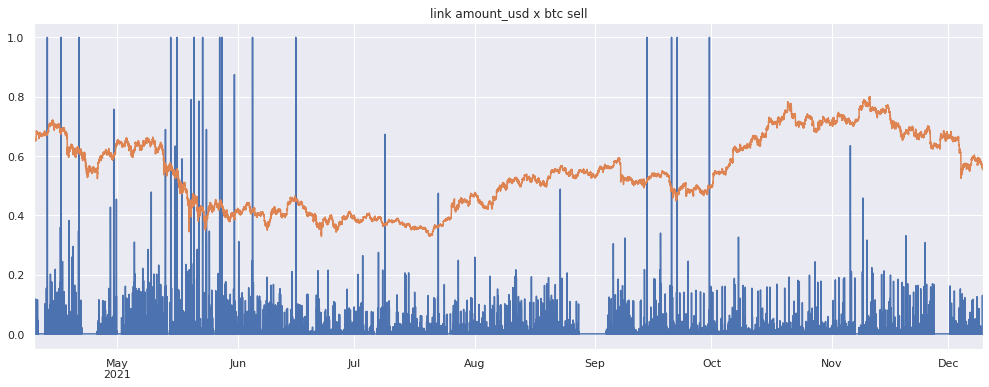

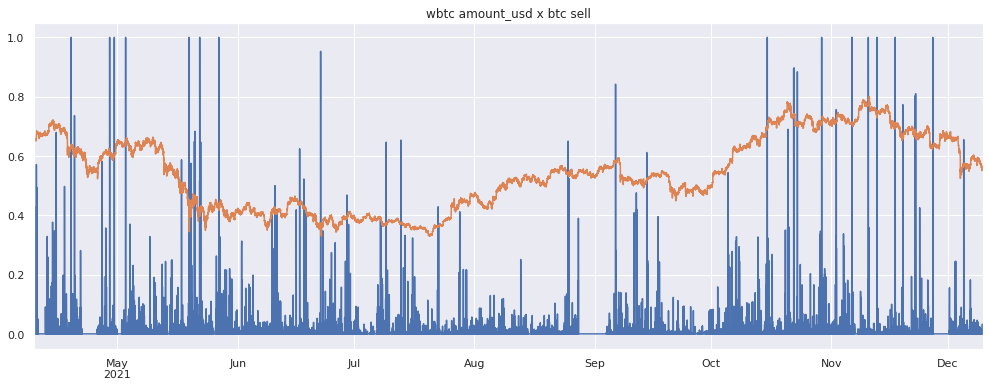

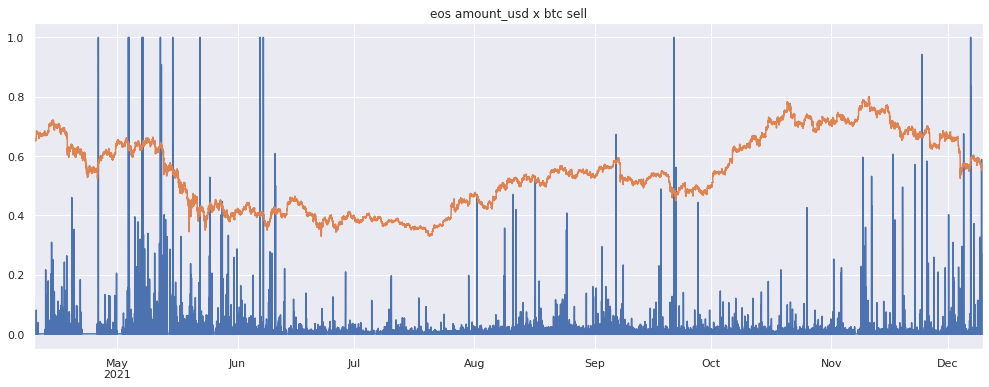

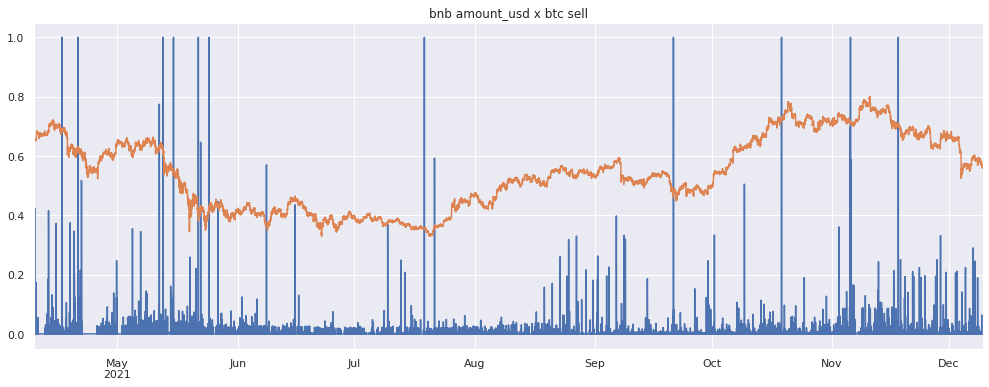

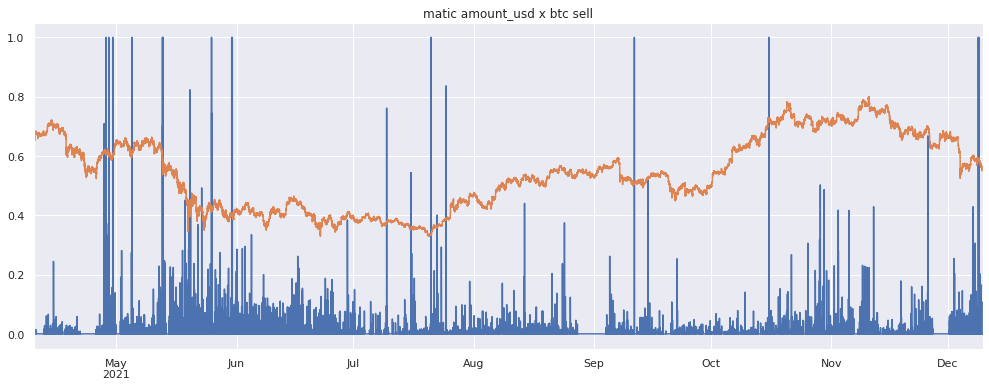

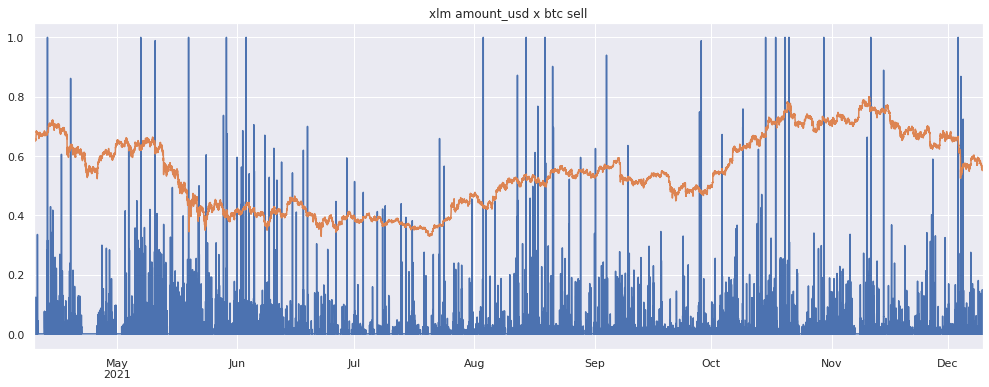

In [86]:
for symbol in df['symbol'].value_counts().sort_values(ascending=False)[:15].index:
    df_whale_symbol_5min = df[df['symbol']==symbol].set_index('datetime_jst').resample('5T').sum()
    df_btc_return_whale_symbol = pd.merge(
        df_whale_symbol_5min, df_btc_return,
        how='inner',
        left_index=True, right_index=True,
    )
    plt.figure(figsize=(17, 6))
    clip = df_btc_return_whale_symbol['amount_usd'].quantile(0.9998)
    amount_usd_max = (df_btc_return_whale_symbol['amount_usd'].clip(0, clip)/clip).max()
    amount_usd_mean = (df_btc_return_whale_symbol['amount_usd'].clip(0, clip)/clip).mean()
    (df_btc_return_whale_symbol['amount_usd'].clip(0, clip)/clip).plot()
    (0.8*amount_usd_max*(df_btc_return_whale_symbol['price_sell'].div(df_btc_return_whale_symbol['price_sell'].max()))).plot()
    plt.title(f'{symbol} amount_usd x btc sell')
    plt.show()